In [119]:
from __future__ import print_function, division

In [120]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### read in datasets

In [124]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


month_ds_dict = {} 
orig_month_ds_dict = {}

for month in months: 
    month_ds_dict[month] = xr.open_dataset(f'./output/{month}_300s_43200ts_ds')
    orig_month_ds_dict[month] = xr.open_dataset(f'./output/{month}_orig_43200ts_ds')

#### parameters for plots

In [125]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076

month1 = 'December'
month2 = 'June'

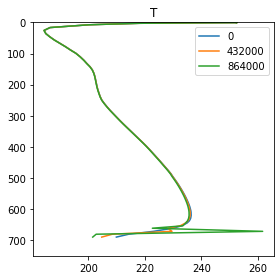

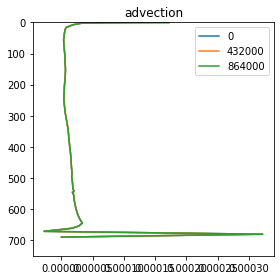

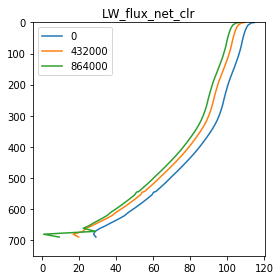

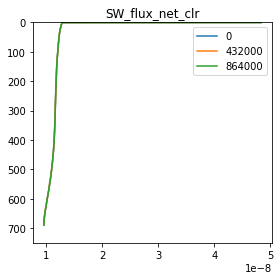

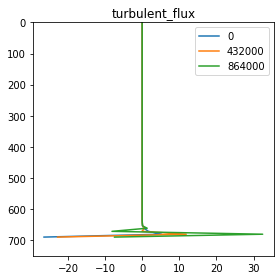

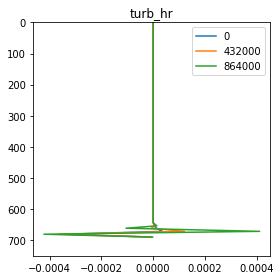

In [126]:
month = month2
for output in ['T','advection', 'LW_flux_net_clr', 'SW_flux_net_clr', 'turbulent_flux', 'turb_hr']:
    fig, axes = plt.subplots(1, 1, figsize = (4,4))
    for t in month_ds_dict[month].time[::5][:3].values:
        plt.plot(model[month].sel(co2_lev = .00038, model = 'rat', time = t)[output], model[month].sel(co2_lev = .00038, model = 'rat')['lev_full'], label = t);
        plt.ylim(750,0)
        #plt.xlim(190,270)
        plt.legend()
        plt.tight_layout()
        plt.title(output)
        

In [152]:
,'advection', 'turbulent_flux', 'turb_hr', 'LW_flux_net_clr', 'SW_flux_net_clr'

array(12960000)

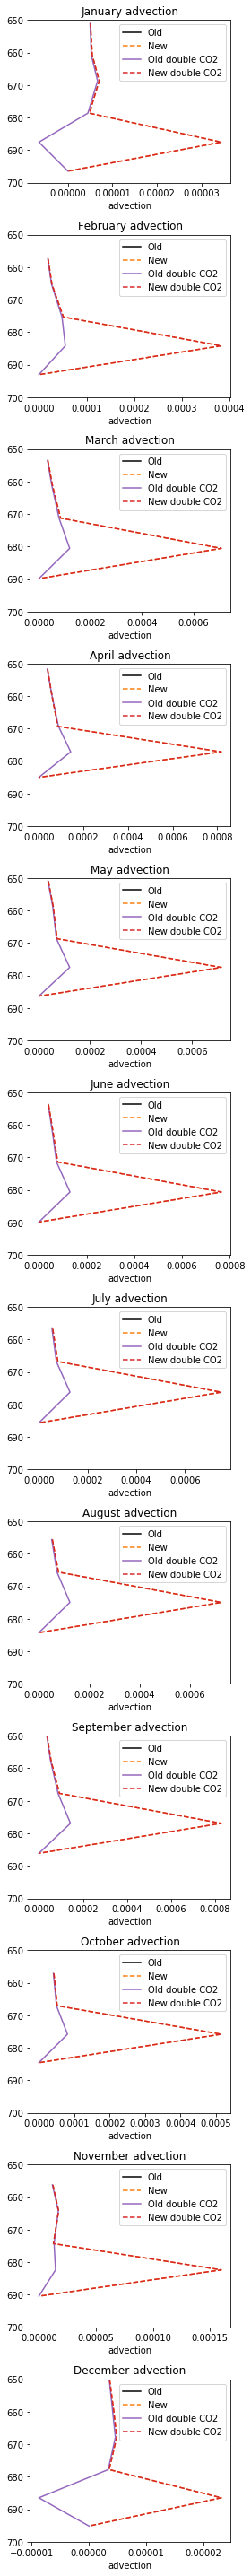

In [264]:
time1 = orig_month_ds_dict['January']['time'][0].values
time2 = orig_month_ds_dict['January']['time'][-1].values
co2_lev1 = .00038
co2_lev2 = .00076
model = month_ds_dict

ylim = 650
for output in ['advection']:
    fig, axes = plt.subplots(12, 1, figsize = (4,40))
    for idx, month in enumerate(months):
        ax = axes[idx]
        
        y = orig_month_ds_dict[month].sel(co2_lev = co2_lev1, model = 'rat', time = time2)[output]
        x = orig_month_ds_dict[month].sel(co2_lev = co2_lev1, model = 'rat', time = time2)['lev_full']
        
        yidx = y > ylim
        y = y[yidx]
        x = x[yidx]
        
        ax.plot(y,
                x, 
                color = 'k',
                label = 'Old'
               )
        
        
        x= month_ds_dict[month].sel(co2_lev = co2_lev1, model = 'rat', time = time2)[output]
        y = month_ds_dict[month].sel(co2_lev = co2_lev1, model = 'rat', time = time2)['lev_full']
        
        yidx = y > ylim
        y = y[yidx]
        x = x[yidx]
        
        ax.plot(x,
                y, 
                color = 'C1',
                linestyle = '--',
                label = 'New'
               )
        
        x = orig_month_ds_dict[month].sel(co2_lev = co2_lev2, model = 'rat', time = time2)[output]
        y = orig_month_ds_dict[month].sel(co2_lev = co2_lev2, model = 'rat', time = time2)['lev_full']
        
        yidx = y > ylim
        y = y[yidx]
        x = x[yidx]
        
        ax.plot(x,
                y, 
                color = 'C4',
                label = f'Old double CO2'
               )
        
        
        x = month_ds_dict[month].sel(co2_lev = co2_lev2, model = 'rat', time = time2)[output]
        y = month_ds_dict[month].sel(co2_lev = co2_lev2, model = 'rat', time = time2)['lev_full']
        
        yidx = y > ylim
        y = y[yidx]
        x = x[yidx]
        
        ax.plot(x,
                y, 
                color = 'C3',
                linestyle = '--',
                label = f'New double CO2'
               )
        
        ax.legend()
        ax.set_xlabel(output)
        ax.set_ylim([700,ylim])
       # ax.set_xlim([x.min(),x.max()])
        ax.set_title(month + ' ' + output)
        plt.tight_layout()

(700, 650)

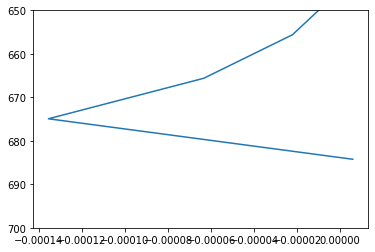

In [266]:
x = orig_month_ds_dict['August']['turb_hr'].sel(co2_lev = .00038, model = 'rat').isel(time = 0)
y = orig_month_ds_dict['August']['lev_full']
plt.plot(x,y)
plt.ylim([700,650])

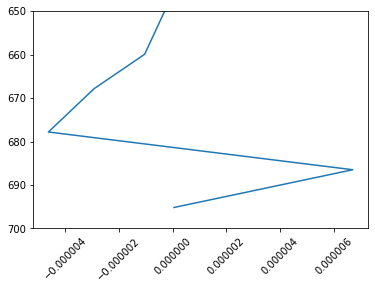

In [268]:
x = orig_month_ds_dict['December']['turb_hr'].sel(co2_lev = .00038, model = 'rat').isel(time = 0)
y = orig_month_ds_dict['December']['lev_full']
plt.plot(x,y)
plt.ylim([700,650])
plt.xticks(rotation = 45);

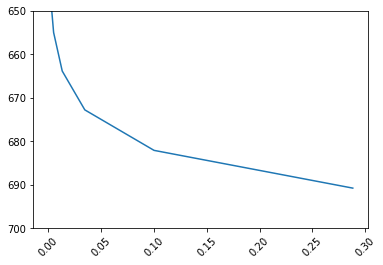

In [270]:
x = orig_month_ds_dict['December']['diffk'].sel(co2_lev = .00038, model = 'rat').isel(time = 0)
y = orig_month_ds_dict['December']['lev_bounds']
plt.plot(x,y)
plt.ylim([700,650])
plt.xticks(rotation = 45);

### find entire column energy balance

In [198]:
month_ds_dict['January']['time'][-1] - month_ds_dict['January']['time'][-2]

<xarray.DataArray 'time' ()>
array(86400)

In [228]:
#time we're looking at
time = month_ds_dict['January']['time'][-2]
month = month1
co2 = 0.00038
timestep = 300

In [234]:
energy_budget_df = pd.DataFrame(index = pd.MultiIndex(levels=[months, ['rat','ra','rt','r']],
           codes=[[0,0,0,0, 1, 1,1,1, 2, 2,2,2, 3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10, 11, 11, 11, 11], 
                  [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3, 0, 1, 2, 3,]],
                                                     names = ['month','model']), 
                                columns = ['ATM_mass','TOA_rad','SFC_rad','SFC_turb','ATM_adv','ATM_heat','energy_budget'])

orig_energy_budget_df = pd.DataFrame(index = pd.MultiIndex(levels=[months, ['rat','ra','rt','r']],
           codes=[[0,0,0,0, 1, 1,1,1, 2, 2,2,2, 3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10, 11, 11, 11, 11], 
                  [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3, 0, 1, 2, 3,]],
                                                     names = ['month','model']), 
                                columns = ['ATM_mass','TOA_rad','SFC_rad','SFC_turb','ATM_adv','ATM_heat','energy_budget'])

In [239]:
for idx_month, month in enumerate(months):
    for idx_mod, model in enumerate(['rat','ra','rt','r']):
        #atmospheric mass
        energy_budget_df.loc[month, model]['ATM_mass'] = month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['heat_capacity'].sum().values #Pa
        #TOA Frad
        energy_budget_df.loc[month, model]['TOA_rad'] = (month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['SW_flux_net_clr'][0] - month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['LW_flux_net_clr'][0]).values #W/m2
        #Surface Frad
        energy_budget_df.loc[month, model]['SFC_rad'] = (month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['SW_flux_net_clr'][-1] - month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['LW_flux_net_clr'][-1]).values #W/m2
        #Surface Turbulence
        energy_budget_df.loc[month, model]['SFC_turb'] = (month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['turbulent_flux'])[-1].values #W/m2
        #Atmospheric Advection
        energy_budget_df.loc[month, model]['ATM_adv'] = (month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['advection'][:-1].values * month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['heat_capacity']).values.sum()
        #Atmospheric Heating
        energy_budget_df.loc[month, model]['ATM_heat'] = ((month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = (time+288*timestep))['T'].values - month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = (time))['T'].values)[:-1]/(288*timestep) * month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['heat_capacity']).sum().values
    
        
        energy_budget_df.loc[month, model]['energy_budget'] = (energy_budget_df.loc[month, model]['TOA_rad'] - 
                                                               energy_budget_df.loc[month, model]['SFC_rad'] +  
                                                               energy_budget_df.loc[month, model]['SFC_turb'] + 
                                                               energy_budget_df.loc[month, model]['ATM_adv'] - 
                                                               energy_budget_df.loc[month, model]['ATM_heat'])

In [240]:
for idx_month, month in enumerate(months):
    for idx_mod, model in enumerate(['rat','ra','rt','r']):
        #atmospheric mass
        orig_energy_budget_df.loc[month, model]['ATM_mass'] = orig_month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['heat_capacity'].sum().values #Pa
        #TOA Frad
        orig_energy_budget_df.loc[month, model]['TOA_rad'] = (orig_month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['SW_flux_net_clr'][0] - orig_month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['LW_flux_net_clr'][0]).values #W/m2
        #Surface Frad
        orig_energy_budget_df.loc[month, model]['SFC_rad'] = (orig_month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['SW_flux_net_clr'][-1] - orig_month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['LW_flux_net_clr'][-1]).values #W/m2
        #Surface Turbulence
        orig_energy_budget_df.loc[month, model]['SFC_turb'] = (orig_month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['turbulent_flux'])[-1].values #W/m2
        #Atmospheric Advection
        orig_energy_budget_df.loc[month, model]['ATM_adv'] = (orig_month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['advection'][:-1].values * orig_month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['heat_capacity']).values.sum()
        #Atmospheric Heating
        orig_energy_budget_df.loc[month, model]['ATM_heat'] = ((orig_month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = (time+288*timestep))['T'].values - orig_month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = (time))['T'].values)[:-1]/(288*timestep) * orig_month_ds_dict[month].sel(
            model = model, co2_lev = co2, time = time)['heat_capacity']).sum().values
    
        
        orig_energy_budget_df.loc[month, model]['energy_budget'] = (orig_energy_budget_df.loc[month, model]['TOA_rad'] - 
                                                               orig_energy_budget_df.loc[month, model]['SFC_rad'] +  
                                                               orig_energy_budget_df.loc[month, model]['SFC_turb'] + 
                                                               orig_energy_budget_df.loc[month, model]['ATM_adv'] - 
                                                               orig_energy_budget_df.loc[month, model]['ATM_heat'])

In [244]:
energy_budget_df.loc['August']

,ATM_mass,TOA_rad,SFC_rad,SFC_turb,ATM_adv,ATM_heat,energy_budget
model,,,,,,,
rat,6958588.511224489,-104.99219418220389,-25.02404480984504,24.682140170988554,160.502,-0.37340013313987924,105.589
ra,6958588.511224489,-158.2191105133421,0.6407058776150626,0.0,160.502,1.6298747116046972,0.0119564
rt,6958588.511224489,nan,nan,nan,0,0.0,NaN
r,6958588.511224489,nan,nan,0.0,0,0.0,NaN


In [263]:
orig_energy_budget_df.loc['August']

,ATM_mass,TOA_rad,SFC_rad,SFC_turb,ATM_adv,ATM_heat,energy_budget
model,,,,,,,
rat,6958588.511224489,-105.3850958370541,-25.304956869394616,-25.023358156294314,102.203,-0.334809744723145,-2.56568
ra,6958588.511224489,-102.86354380541,-0.3504420655336376,0.0,102.203,-0.3082863773631386,-0.0018035
rt,6958588.511224489,nan,nan,nan,0,0.0,NaN
r,6958588.511224489,nan,nan,0.0,0,0.0,NaN


In [259]:
orig_energy_budget_df.loc['December']

,ATM_mass,TOA_rad,SFC_rad,SFC_turb,ATM_adv,ATM_heat,energy_budget
model,,,,,,,
rat,7073979.819183674,-20.05443693185279,0.3959163349255732,0.3418762611014535,20.368,0.13635674219931412,0.123143
ra,7073979.819183674,-20.172643982387683,0.05452414698781638,0.0,20.368,0.13943146307007687,0.00137681
rt,7073979.819183674,-0.8291503957645148,1.0936501759219084,1.3186774561922079,0,-0.8465033888311423,0.24238
r,7073979.819183674,-1.0742058063658817,-0.2185221993787394,0.0,0,-0.8484221766864571,-0.00726143


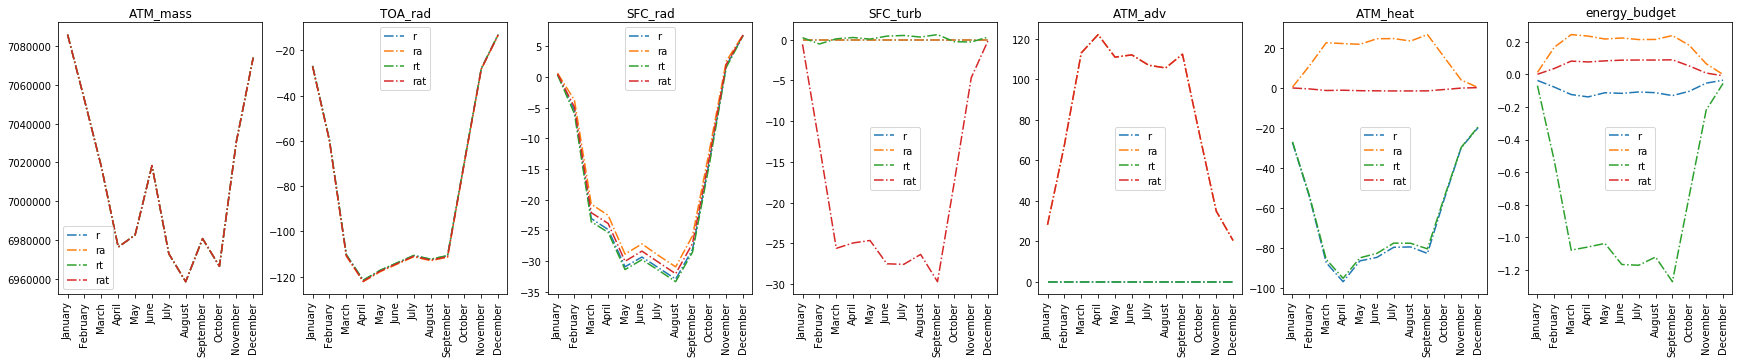

In [88]:
fig, axes = plt.subplots(1,7, figsize = (30, 5))
colors = cm.twilight(np.linspace(0,1,4))
for idx, result in enumerate(energy_budget_df.columns.values):
    ax = axes[idx]
    for model in ['r','ra','rt','rat']:
        ax.plot(energy_budget_df.query(f'model == "{model}"').index.get_level_values(0), energy_budget_df.query(f'model == "{model}"')[result], '-.', label = f'{model}')
    ax.legend()
    ax.set_xticklabels(labels = energy_budget_df.query(f'model == "{model}"').index.get_level_values(0),rotation = 90);
    ax.set_title(result)

In [89]:
energy_budget_df.loc['January','rat']['ATM_adv']

28.114690049498773

#### plot ASR and OLR over time

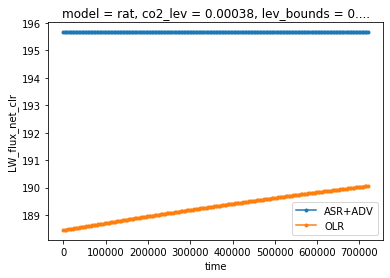

In [90]:
(month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['SW_flux_net_clr'][0]+energy_budget_df.loc[month,'rat']['ATM_adv']).plot(marker = '.', label = 'ASR+ADV')
month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['LW_flux_net_clr'][0].plot(marker = '.', label = 'OLR')
plt.legend()

#### greenhouse effect

#### plot the temperature difference between double and normal CO2 scenario

In [97]:
month = 'June'

(700, -50)

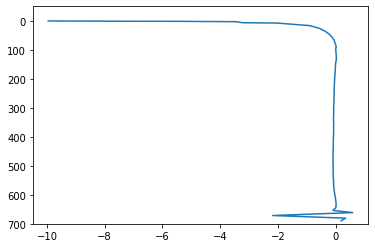

In [98]:
plt.plot((month_ds_dict[month].sel(
    model = 'rat', co2_lev = .00076, time = 200*3600)['T'] - month_ds_dict[month].sel(
    model = 'rat', co2_lev = .00038, time = 200*3600)['T']), month_ds_dict[month]['lev_full'])
plt.ylim(700,-50)

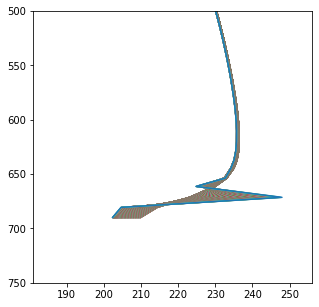

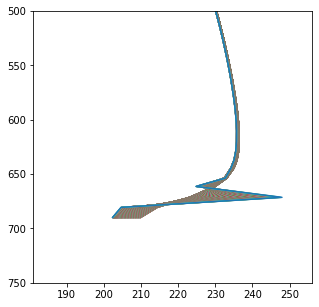

In [99]:
for co2 in [.00038,.00076]:
    fig, ax = plt.subplots(figsize = [5,5])
    for t in month_ds_dict[month]['time'].values:
        plt.plot(month_ds_dict[month].sel(
            model = 'rat', co2_lev = .00038, time = t)['T'],  month_ds_dict[month]['lev_full'])
        plt.ylim(750,500)

#### solar insolation

#### absorption coefficients and pressure

In [22]:
# estimate the absorption coefficient for CO2 = 1e-4 m2/kg
# P*CO2 mixing ratio * absorption coefficient / g = 1
# so g/CO2 mixing ratio /absorption coefficient = P

g = 9.8 #m/s2
mmr = 200*1e-6#ppm
abs_coef = 1

P = g/(mmr*abs_coef) #kg*s2/ m
P/100

490.00000000000006

In [207]:
wl = 15 #um
wn = 1/wl * 1e4
wn

666.6666666666666

#### standard atmosphere vs antarctic

In [259]:
#### compare between our antarctic version and a normal atmosphere
alb = 0.25
#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=30)
#  Parent model process
rcm = climlab.TimeDependentProcess(state=state)
#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=alb)
#  Convective adjustment
conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
#  Couple everything together
rcm.add_subprocess('Radiation', rad)
rcm.add_subprocess('WaterVapor', h2o)
rcm.add_subprocess('Convection', conv)
#  Run the model
rcm.integrate_years(1)


Opened data from /opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


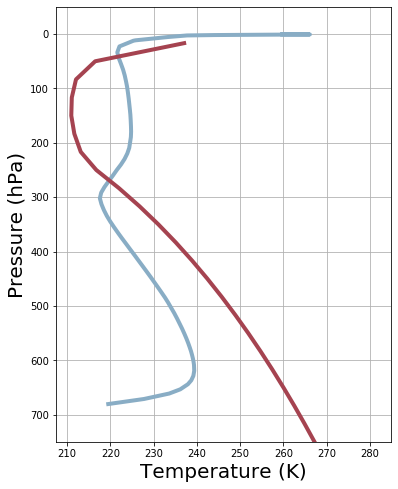

In [263]:
fig, ax = plt.subplots(figsize = [6,8])
colors=cm.twilight(np.linspace(0,1,8))
for month in ['March']:
    #plot our antarctic atmosphere
    x = np.asarray(results_dict[0]['Tatm'][0.00038][month])
    y = results_dict[0]['lev'][0.00038][month]
    plt.plot(x, y, c = colors[1], lw = 4)
    
    #plot standard atmosphere
    plt.plot(rcm.state['Tatm'], rcm.lev, c= colors[5], lw = 4)
    
    #labels and lims
    plt.ylabel('Pressure (hPa)', fontsize = 20)
    plt.xlabel('Temperature (K)', fontsize = 20)
    plt.ylim([750,-50])
plt.grid()
plt.savefig('../figures/stp_antarctic_comp.png', dpi = 150, bbox_inches = 'tight')

In [ ]:
for month in months:
    for co2 in co2_lev:
        for time in np.arange(0,((steps+1)*timestep),timestep):
            for model in model_dict.keys():
                
                #TOA Frad
                month_ds_dict[month]['F_rad_toa'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['SW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[0]) - np.asarray(month_ds_dict[month]['LW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[0]) #W/m2

                #Surface Frad
                month_ds_dict[month]['F_rad_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['SW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[-1]) - np.asarray(month_ds_dict[month]['LW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[-1]) #W/m2

                #Surface Fturb
                month_ds_dict[month]['F_turb_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['turbulent_flux'].sel(co2_lev = co2, time = time, model = model)[-1]) #W/m2

                month_ds_dict[month]['F_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = model_dict[model][F_rad_sfc].loc[dict(co2_lev = co2, time = time, model = dict_name)] - model_dict[model][F_turb_sfc].loc[dict(co2_lev = co2, time = time, model = dict_name)]
                #dT/dt
                month_ds_dict[month]['total_atm_hr'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = ((np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time+timestep, model = model)) - 
                                np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)))[:-1]/np.asarray(timestep)) #K/s

                #dz
                month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.diff(month_ds_dict[month]['z_bounds']) #surface to atmosphere #m

                #heat capacity (density*cp)
                month_ds_dict[month]['R'] = 8.314 #J/mol/K
                month_ds_dict[month]['MW_air'] = 0.0289647 #kg/mol
                month_ds_dict[month]['pressure_TOA'] = 100*month_ds_dict[month]['lev'][-1] #pascal (kg/m/s2)
                month_ds_dict[month]['density_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = (month_ds_dict[month]['MW_air']*100*month_ds_dict[month]['lev'])/(np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)[:-1]) * month_ds_dict[month]['R']) #kg/m^3
                month_ds_dict[month]['cp_air'] = 1003 #specific heat of air (at 250 K) J/(kg*K)
                month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = month_ds_dict[month]['density_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)]*month_ds_dict[month]['cp_air']

                #atmospheric heat content rate at each level
                month_ds_dict[month]['total_atm_heat_content_rate'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = month_ds_dict[month]['total_atm_hr'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] #W/m2

                #advective flux at each level
                month_ds_dict[month]['total_adv_flux'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['advection'].sel(co2_lev = co2, time = time, model = model)[:-1]) * month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] #W/m2
                
                